In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio

The following function assemble the matrices from
the influence coefficients.

In [3]:
def assem(coords, elems):
    """Assembly matrices for the BEM problem

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.

    Returns
    -------
    Gmat : ndarray, float
        Influence matrix for the flow.
    Fmat : ndarray, float
        Influence matrix for primary variable.
    """
    nelems = elems.shape[0]
    Gmat = np.zeros((nelems, nelems))
    Fmat = np.zeros((nelems, nelems))
    for ev_cont, elem1 in enumerate(elems):
        for col_cont, elem2 in enumerate(elems):
            pt_col = mean(coords[elem2], axis=0)
            if ev_cont == col_cont:
                L = norm(coords[elem1[1]] - coords[elem1[0]])
                Gmat[ev_cont, ev_cont] = - L/(2*pi)*(log(L/2) - 1)
                Fmat[ev_cont, ev_cont] = - 0.5
            else:
                Gij, Fij = influence_coeff(elem1, coords, pt_col)
                Gmat[ev_cont, col_cont] = Gij
                Fmat[ev_cont, col_cont] = Fij
    return Gmat, Fmat

The influence coefficients are computed analytically
as

In [4]:
def influence_coeff(elem, coords, pt_col):
    """Compute influence coefficients

    Parameters
    ----------
    elems : ndarray, int
        Connectivity for the elements.
    coords : ndarray, float
        Coordinates for the nodes.
    pt_col : ndarray
        Coordinates of the colocation point.

    Returns
    -------
    G_coeff : float
        Influence coefficient for flows.
    F_coeff : float
        Influence coefficient for primary variable.
    """
    dcos = coords[elem[1]] - coords[elem[0]]
    dcos = dcos / norm(dcos)
    rotmat = np.array([[dcos[1], -dcos[0]],
                       [dcos[0], dcos[1]]])
    r_A = rotmat.dot(coords[elem[0]] - pt_col)
    r_B = rotmat.dot(coords[elem[1]] - pt_col)
    theta_A = arctan2(r_A[1], r_A[0])
    theta_B = arctan2(r_B[1], r_B[0])
    if norm(r_A) <= 1e-6:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0]
    elif norm(r_B) <= 1e-6:
        G_coeff = -(r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    else:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0] -\
                  (r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    F_coeff = theta_B - theta_A
    return -G_coeff/(2*pi), F_coeff/(2*pi)

The following function evaluate the solution
to the nodes in the 2D mesh.

In [5]:
def eval_sol(ev_coords, coords, elems, u_boundary, q_boundary):
    """Evaluate the solution in a set of points

    Parameters
    ----------
    ev_coords : ndarray, float
        Coordinates of the evaluation points.
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.
    u_boundary : ndarray, float
        Primary variable in the nodes.
    q_boundary : [type]
        Flows in the nodes.

    Returns
    -------
    solution : ndarray, float
        Solution evaluated in the given points.
    """
    npts = ev_coords.shape[0]
    solution = np.zeros(npts)
    for k in range(npts):
        for ev_cont, elem in enumerate(elems):        
            pt_col = ev_coords[k]
            G, F = influence_coeff(elem, coords, pt_col)
            solution[k] += u_boundary[ev_cont]*F - q_boundary[ev_cont]*G
    return solution

Now, let us run a simulation.

In [7]:
mesh = meshio.read("files/single_plate_bnd.msh")
elems = np.vstack([cells.data for cells in mesh.cells[0:4]])
bound_nodes = list(set(elems.flatten()))
coords = mesh.points[bound_nodes, :2]
x, y = coords.T

In [8]:
u_boundary = np.ones(elems.shape[0])

In [9]:
Gmat, Fmat = assem(coords, elems)

In [10]:
q_boundary = solve(Gmat, Fmat.dot(u_boundary))

## Evaluation

In [13]:
mesh_eval = meshio.read("files/single_plate.msh")


In [14]:
ev_coords =  mesh_eval.points[:, :2]
ev_x, ev_y = ev_coords.T
solution = eval_sol(ev_coords, coords, elems, u_boundary, q_boundary)

Visualization

<IPython.core.display.Javascript object>


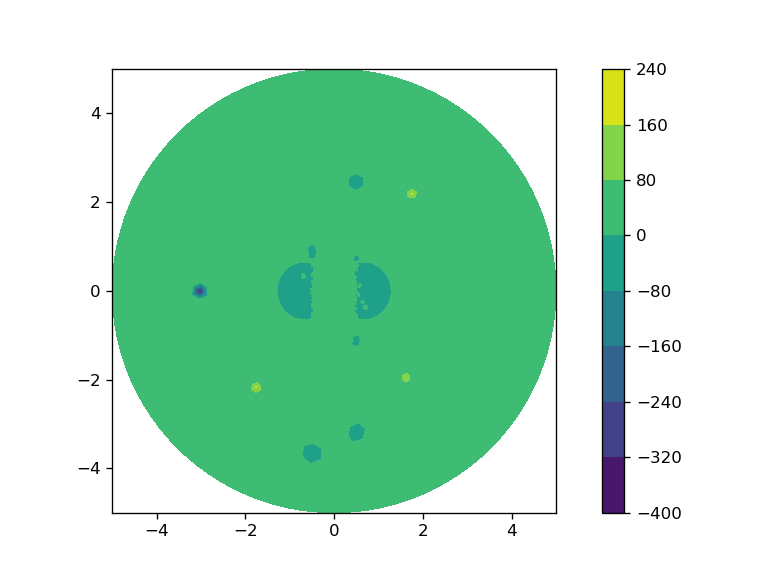

(-4.997532802157822, 4.997532802157822, -4.997532802152623, 4.997532802152623)

In [18]:
tris = mesh_eval.cells[4].data
fig = plt.figure()
plt.tricontourf(ev_x, ev_y, tris, solution)
plt.colorbar()
plt.axis("image")

In [18]:
mesh_eval.point_data["potential"] = solution

In [19]:
mesh_eval.write("files/parallel_plates.vtk")

In [15]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = 'custom.css'
HTML(open(css_file, "r").read())